<img src="https://insidesherpa.s3.amazonaws.com/vinternships/companyassets/32A6DqtsbF7LbKdcq/9F4wA4B5J6Kgmef3k/White%20logo%20croppd.png" style="background: black ; width: 200px;padding: 5px;border-radius: 5px;">

<h1>Task 2 : Experimentation and uplift testing</h1>
<p>Extending the analysis from Task 1 to help identify benchmark stores that allow you to test the impact of the trial store layouts on customer sales.</p>

<b>TASK </b>: To identify effect of product layouts in purchase behaviour and sales of 3 Trial Stores, **77**, **86** and **88** in the trail period Feb 2019 to April 2019.


<b>APPROACH </b>: 
* Select control stores that are similar in performance to the trial stores on the basis of correlation of
    - Monthly overall sales revenue,
    - Monthly number of customers,
    - Monthly number of transactions per customer
* Assess the trail i.e. test if total sales are significantly different in the trial period and if so, check if the driver of change is more purchasing customers or more purchases per customers etc.

<hr>

<b>Importing Libraries</b>

In [1]:

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import plotly.express as px

from scipy.stats import ks_2samp,ttest_ind


<b>Reading Data</b>

In [2]:
df = pd.read_csv('QVI_data.csv', parse_dates=[1])
print(df.shape)
df.head(2)

(264834, 12)


,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream


<br>

<b>Creating new feature YYYYMM to generate control stores metrics on monthly basis</b>

In [3]:
df['YEAR_MONTH'] = df.DATE.dt.to_period('M')
df.head(2)

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEAR_MONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,2018-10
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,2018-09


<br>

<b>Generating performance metrics for all stores</b>

In [4]:

def calcStorePerf(store, start=0, end=7):
    '''
    Takes a store number as input and returns monthly
    sales, number of customers and number of transactions
    as output in a tuple. 
    Start and end can be used to slice the data.
    
    input - calcStorePerf(22)
    output - (YEAR_MONTH
              2018-07    309.2
              2018-08    201.2
              ...        ...
              ...        ...
              2018-12    39
              2019-01    55
              Freq: M, Name: TXN_ID, dtype: int64)
    '''
    
    sales = df[df.STORE_NBR == store].groupby('YEAR_MONTH')['TOT_SALES'].sum().iloc[start:end]
    customers = df[df.STORE_NBR == store].groupby('YEAR_MONTH')['LYLTY_CARD_NBR'].unique().apply(lambda x: len(x)).iloc[start:end]
    trancs = df[df.STORE_NBR == store].groupby('YEAR_MONTH')['TXN_ID'].unique().apply(lambda x: len(x)).iloc[start:end]
    
    return sales, customers, trancs


In [5]:

# Calculating perfomance metrics for all stores
# and storing them in a dict with key as store name
all_store_perf = dict()
for i,st in enumerate(df.STORE_NBR.unique()):
    perf = calcStorePerf(st)
    if len(perf[0]) == 7:
        all_store_perf[st] = perf
    

# Dataframes to store pearson correlation score of 
# each trial store with every other store.
store_77_neigh = pd.DataFrame(columns=['SALES_CORR', 'CUST_CORR', 'TRANS_CORR'])
store_86_neigh = pd.DataFrame(columns=['SALES_CORR', 'CUST_CORR', 'TRANS_CORR'])
store_88_neigh = pd.DataFrame(columns=['SALES_CORR', 'CUST_CORR', 'TRANS_CORR'])

for i in all_store_perf.keys():
    store_77_neigh.loc[i, 'SALES_CORR']= all_store_perf[77][0].corr(all_store_perf[i][0], method='pearson')
    store_77_neigh.loc[i, 'CUST_CORR']= all_store_perf[77][1].corr(all_store_perf[i][1], method='pearson')
    store_77_neigh.loc[i, 'TRANS_CORR']= all_store_perf[77][2].corr(all_store_perf[i][2], method='pearson')
    store_86_neigh.loc[i, 'SALES_CORR']= all_store_perf[86][0].corr(all_store_perf[i][0], method='pearson')
    store_86_neigh.loc[i, 'CUST_CORR']= all_store_perf[86][1].corr(all_store_perf[i][1], method='pearson')
    store_86_neigh.loc[i, 'TRANS_CORR']= all_store_perf[86][2].corr(all_store_perf[i][2], method='pearson')
    store_88_neigh.loc[i, 'SALES_CORR']= all_store_perf[88][0].corr(all_store_perf[i][0], method='pearson')
    store_88_neigh.loc[i, 'CUST_CORR']= all_store_perf[88][1].corr(all_store_perf[i][1], method='pearson')
    store_88_neigh.loc[i, 'TRANS_CORR']= all_store_perf[88][2].corr(all_store_perf[i][2], method='pearson')
    


***

## Trial Store 77
<p>Now we will rank all the stores based on correlation scores to find out control store for store 77.</p>

In [6]:
store_77_neigh.sort_values('SALES_CORR', ascending=False)

,SALES_CORR,CUST_CORR,TRANS_CORR
77,1,1,1
71,0.914106,0.754817,0.867547
233,0.903774,0.990358,0.958422
119,0.867664,0.983267,0.94007
17,0.842668,0.747308,0.808263
...,...,...,...
158,-0.709319,-0.300172,-0.423145
24,-0.718112,-0.425258,-0.484627
244,-0.774513,-0.399044,-0.501914
75,-0.806751,-0.590735,-0.641599


It is difficult to observe and compare 263 numerical values in a tabular form to below we represent them graphically. 


Here we observe that by sorting based on total sales, the other two metrics that are no. of customers and no. of transactions are also following total sales pattern automatically upto a large extent.

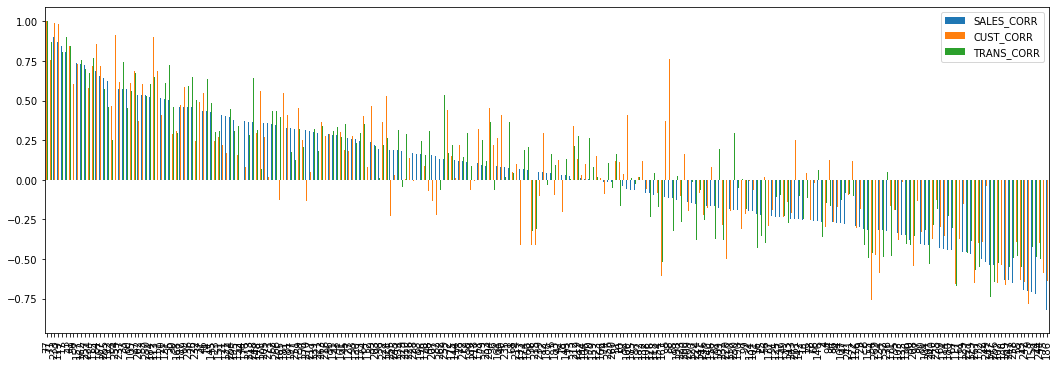

In [7]:
store_77_neigh.sort_values('SALES_CORR', ascending=False).plot(kind='bar', figsize=(18,6))

plt.show()

By zooming in to both the extreme corners in the below figure we observe that Store 233 and 119 seemes to have high correlation scores across all three metrics. We can choose either so **we choose Store 233 as our control store for trial store 77**.

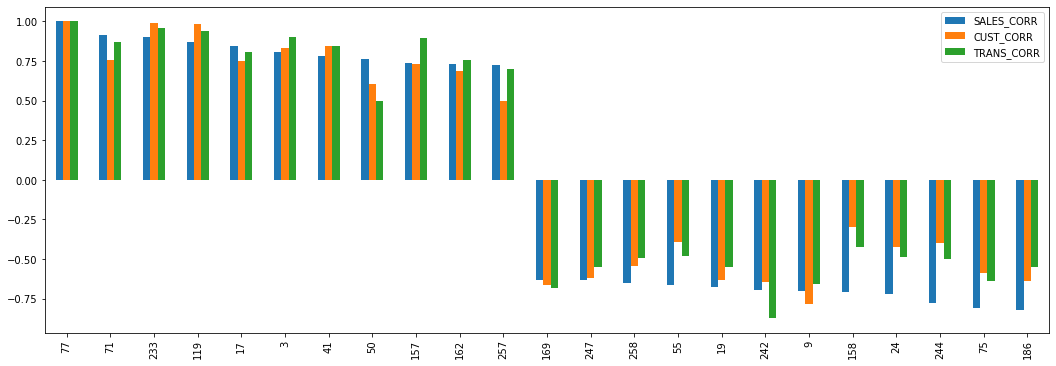

In [8]:
store_77_neigh[(store_77_neigh.SALES_CORR >= 0.7) | (store_77_neigh.SALES_CORR <= -0.6)].sort_values('SALES_CORR', ascending=False).plot(kind='bar', figsize=(18,6))

<br>

Now that we have selected Store 233 as a control store, we check how similar the distributions of Store 77 are similar to this store.


We check the distribution of following metrics from July 2018 to Jan 2019 i.e. before the trail period.
* Total Sales,
* No. of customer, and
* No. of transactions

<b>Total Sales Distribution</b>
<p>Both the pdfs are overlapping visually</p>

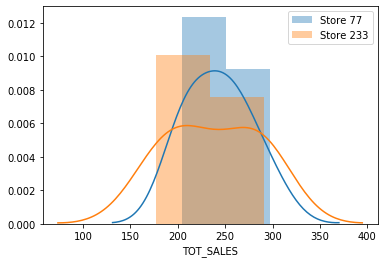

In [9]:
sns.distplot(all_store_perf[77][0], label=('Store 77'))
sns.distplot(all_store_perf[233][0], label=('Store 233'))

plt.legend()
plt.show()

<b>No. of Customer each month distribution</b>
<p>Here also we observe overlapping distributions</p>

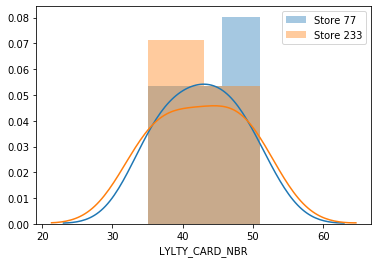

In [10]:
sns.distplot(all_store_perf[77][1], label=('Store 77'))
sns.distplot(all_store_perf[233][1], label=('Store 233'))

plt.legend()
plt.show()

<b>No. of Transactions each month distribution</b>
<p>Distributions seems to be overlapping here as well.</p>

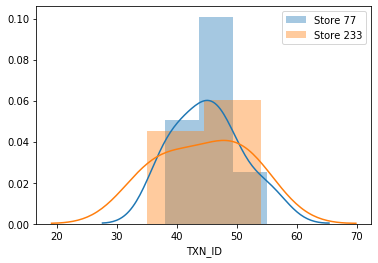

In [11]:
sns.distplot(all_store_perf[77][2], label=('Store 77'))
sns.distplot(all_store_perf[233][2], label=('Store 233'))

plt.legend()
plt.show()

<br>

To be sure that all above distributions of Store 233 are not significantally different from Store 77 we employ **Kolmogorov-Smirnov Statistic**.


This tests whether 2 samples are drawn from the same distribution. If the KS statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.


[Official Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html#scipy.stats.ks_2samp)

<b>NULL HYPOTHESIS </b>: Distributions of the two samples are the same.

In [12]:
# Total Sales

ks_2samp(all_store_perf[77][0], all_store_perf[233][0])

Ks_2sampResult(statistic=0.2857142857142857, pvalue=0.9627039627039629)

For total sales we see that the KS statistic is small or the p-value is high, therefore we cannot reject the hypothesis that the distributions of the two samples are the same.

In [13]:
# Number of Customers

ks_2samp(all_store_perf[77][1], all_store_perf[233][1])

Ks_2sampResult(statistic=0.14285714285714285, pvalue=0.9999997041284721)

For number of customers also we see that the p-value is high, therefore we cannot reject the hypothesis that the distributions of the two samples are the same.

In [14]:
# Number of Transactions

ks_2samp(all_store_perf[77][2], all_store_perf[233][2])

Ks_2sampResult(statistic=0.2857142857142857, pvalue=0.9627039627039629)

Here also we see that the p-value is high, therefore we cannot reject the hypothesis that the distributions of the two samples are the same.

<hr>

## Assessment of the trial

The trial period goes from the start of February 2019 to April 2019. We now want tosee if there has been an uplift in overall chip sales.


As our null hypothesis is that the trial period is the same as the pre-trial period, we will employ **T-test** for the means of two independent samples of scores to find whether the difference is significant or not.
 

We can use this test, if we observe two independent samples from the same or different population, e.g. exam scores of boys and girls or of two ethnic groups. The test measures whether the average (expected) value differs significantly across samples. If we observe a large p-value, for example larger than 0.05 or 0.1, then we cannot reject the null hypothesis of identical average scores. If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages.

[Official Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)

[Reference reading material](https://www.statisticshowto.com/t-statistic/)


**We will test with a null hypothesis of there being 0 difference between trial and control stores.**

<br>

We calculate the performance metrics of trial store and control store for trial period which is from Feb 2019 to April 2019.

In [15]:
trial_77 = calcStorePerf(77, start=8, end=11)
trial_233 = calcStorePerf(233, start=8, end=11)

<br>

<b>T-Test on Total Sales</b>

In [16]:
ttest_ind(trial_77[0], trial_233[0])

Ttest_indResult(statistic=0.8089929689834496, pvalue=0.46389125242593654)

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for Feb and April - i.e. the **increase in sales in the trial store in March and April is statistically greater than in the control store**.


Below we check distributions during the trail period and observe that they also seems different visually.

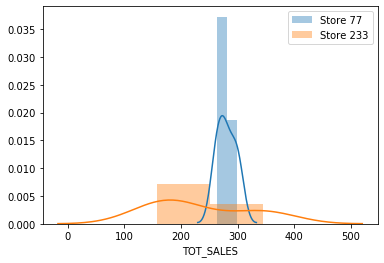

In [17]:
sns.distplot(trial_77[0], label=('Store 77'))
sns.distplot(trial_233[0], label=('Store 233'))

plt.legend()
plt.show()

T-Test on Number of Customers

Ttest_indResult(statistic=1.0138838820672655, pvalue=0.3679815690241426)


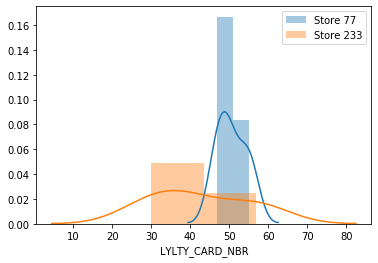

In [18]:
print(ttest_ind(trial_77[1], trial_233[1]))

sns.distplot(trial_77[1], label=('Store 77'))
sns.distplot(trial_233[1], label=('Store 233'))

plt.legend()
plt.show()

<b>CONCLUSION</b>

The results show that the trial in store 77 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

***

## Trial Store 86
<p>Now we will repeat the same process for Store 86. Fist we rank all the stores based on correlation scores to find out control store for store 77.</p>

In [19]:
store_86_neigh.sort_values('SALES_CORR', ascending=False)

,SALES_CORR,CUST_CORR,TRANS_CORR
86,1,1,1
155,0.877882,0.942876,0.642294
132,0.846517,0.565036,0.634413
240,0.825066,0.576403,0.632894
222,0.795075,0.458238,0.596494
...,...,...,...
254,-0.793506,-0.529573,-0.65675
39,-0.808121,-0.139272,-0.782324
108,-0.840413,-0.697245,-0.611855
256,-0.847401,-0.59078,-0.609045


Here we observe that by sorting based on total sales, the other two metrics that are no. of customers and no. of transactions are also following total sales pattern automatically upto a large extent.

But observing on large number of numerical values is difficult so we plot them below.

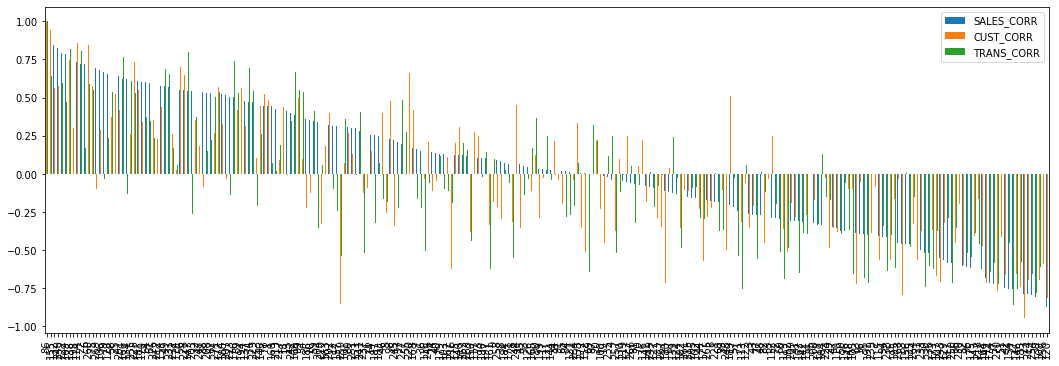

In [20]:
store_86_neigh.sort_values('SALES_CORR', ascending=False).plot(kind='bar', figsize=(18,6))

plt.show()

By zooming in to both the extreme corners in the below figure we observe that Store 155 seemes to have high correlation scores across all three metrics. **We choose Store 155 as our control store for trial store 86**.

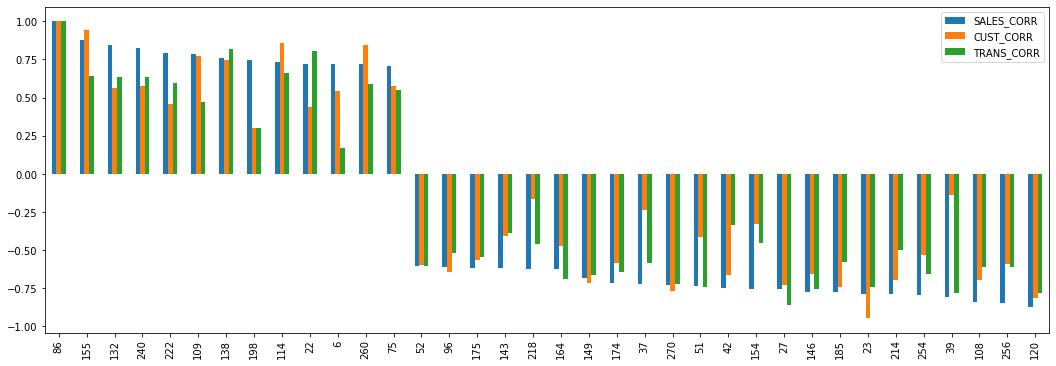

In [21]:
store_86_neigh[(store_86_neigh.SALES_CORR >= 0.7) | (store_86_neigh.SALES_CORR <= -0.6)].sort_values('SALES_CORR', ascending=False).plot(kind='bar', figsize=(18,6))

Now that we have selected Store 155 as a control store, we check how similar the distributions of Store 86 are similar to this store.


We check the distribution of following metrics from July 2018 to Jan 2019 i.e. before the trail period.
* Total Sales,
* No. of customer, and
* No. of transactions

<b>Total Sales Distribution</b>
<p>Both the pdfs are overlapping visually</p>

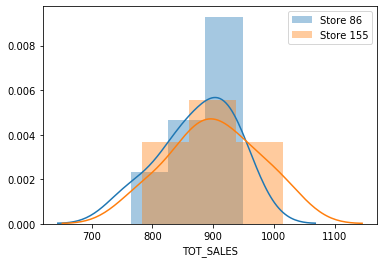

In [22]:
sns.distplot(all_store_perf[86][0], label=('Store 86'))
sns.distplot(all_store_perf[155][0], label=('Store 155'))

plt.legend()
plt.show()

<b>No. of Transactions each month distribution</b>
<p>Distributions seems to be overlapping here as well.</p>

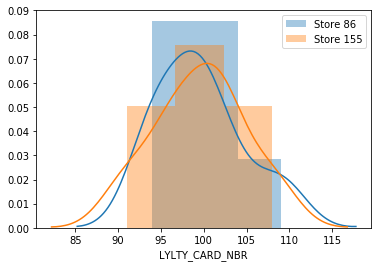

In [23]:
sns.distplot(all_store_perf[86][1], label=('Store 86'))
sns.distplot(all_store_perf[155][1], label=('Store 155'))

plt.legend()
plt.show()

<b>No. of Transactions each month distribution</b>
<p>Distributions seems to be overlapping here as well.</p>

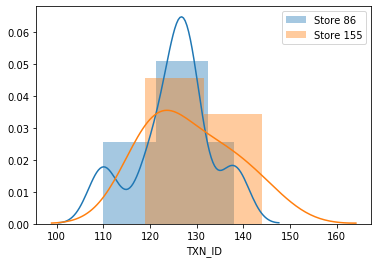

In [24]:
sns.distplot(all_store_perf[86][2], label=('Store 86'))
sns.distplot(all_store_perf[155][2], label=('Store 155'))

plt.legend()
plt.show()

To be sure that all above distributions of Store 155 are not significantally different from Store 86 we employ **Kolmogorov-Smirnov Statistic**.


This tests whether 2 samples are drawn from the same distribution. If the KS statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.


[Official Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html#scipy.stats.ks_2samp)

<b>NULL HYPOTHESIS </b>: Distributions of the two samples are the same.

In [25]:
# Total Sales

ks_2samp(all_store_perf[86][0], all_store_perf[155][0])

Ks_2sampResult(statistic=0.2857142857142857, pvalue=0.9627039627039629)

For total sales we see that the KS statistic is small or the p-value is high, therefore we cannot reject the hypothesis that the distributions of the two samples are the same.

In [26]:
# Number of Customers

ks_2samp(all_store_perf[86][1], all_store_perf[155][1])

Ks_2sampResult(statistic=0.2857142857142857, pvalue=0.9627039627039629)

For number of customers also we see that the p-value is high, therefore we cannot reject the hypothesis that the distributions of the two samples are the same.

In [27]:
# Number of Transactions

ks_2samp(all_store_perf[86][2], all_store_perf[155][2])

Ks_2sampResult(statistic=0.2857142857142857, pvalue=0.9627039627039629)

Here also we see that the p-value is high, therefore we cannot reject the hypothesis that the distributions of the two samples are the same.

<hr>

## Assessment of the trial

The trial period goes from the start of February 2019 to April 2019. We now want tosee if there has been an uplift in overall chip sales.


As our null hypothesis is that the trial period is the same as the pre-trial period, we will employ **T-test** for the means of two independent samples of scores to find whether the difference is significant or not.
 

We can use this test, if we observe two independent samples from the same or different population, e.g. exam scores of boys and girls or of two ethnic groups. The test measures whether the average (expected) value differs significantly across samples. If we observe a large p-value, for example larger than 0.05 or 0.1, then we cannot reject the null hypothesis of identical average scores. If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages.

[Official Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)

[Reference reading material](https://www.statisticshowto.com/t-statistic/)


**We will test with a null hypothesis of there being 0 difference between trial and control stores.**

<br>

We calculate the performance metrics of trial store and control store for trial period which is from Feb 2019 to April 2019.

In [28]:
trial_86 = calcStorePerf(86, start=8, end=11)
trial_155 = calcStorePerf(155, start=8, end=11)

<br>

<b>T-Test on Total Sales</b>

In [29]:
ttest_ind(trial_86[0], trial_155[0])

Ttest_indResult(statistic=0.9987272228835194, pvalue=0.3744477492053499)

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for Feb and April - i.e. the **increase in sales in the trial store in March and April is statistically greater than in the control store**.


Below we check distributions during the trail period and observe that they also seems visually seperable.

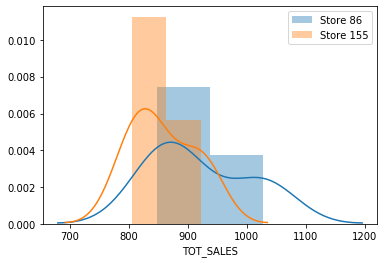

In [46]:
sns.distplot(trial_86[0], label=('Store 86'))
sns.distplot(trial_155[0], label=('Store 155'))

plt.legend()
plt.show()

T-Test on number of Customers

Ttest_indResult(statistic=1.6854996561581044, pvalue=0.16717286957601465)


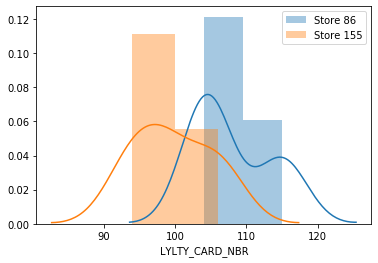

In [45]:
print(ttest_ind(trial_86[1], trial_155[1]))

sns.distplot(trial_86[1], label=('Store 86'))
sns.distplot(trial_155[1], label=('Store 155'))

plt.legend()
plt.show()

<b>CONCLUSION</b>

It looks like the number of customers is significantly higher in all of the three months. This seems to suggest that the trial had a significant impact on increasingthe number of customers in trial store 86 but as we saw, sales were not significantly higher. We should check with the Category Manager if there were special deals in the trial store that were may have resulted in lower prices, impacting the results.

***

## Trial Store 88
<p>Rrepeating the same process for Store 88. Fist we rank all the stores based on correlation scores to find out control store for store 77.</p>

In [32]:
store_88_neigh.sort_values('SALES_CORR', ascending=False)

,SALES_CORR,CUST_CORR,TRANS_CORR
88,1,1,1
159,0.903186,0.217007,0.509753
204,0.885774,0.550263,0.815758
134,0.864293,0.50888,0.956855
1,0.813636,0.305334,0.540631
...,...,...,...
272,-0.772772,0.0269088,-0.401536
23,-0.801652,0.084055,-0.392072
8,-0.816296,-0.301743,-0.362824
48,-0.857142,-0.361505,-0.548104


Here we observe that by sorting based on total sales, the other two metrics that are no. of customers and no. of transactions are also following total sales pattern automatically upto a large extent.

But observing on large number of numerical values is difficult so we plot them below.

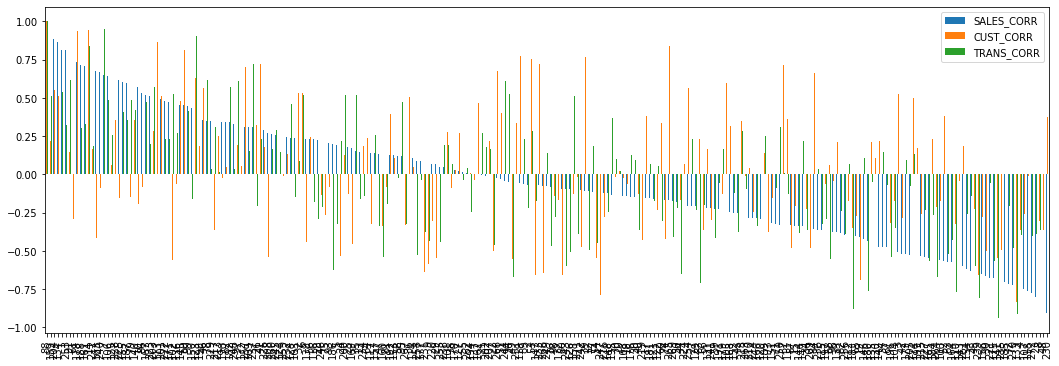

In [33]:
store_88_neigh.sort_values('SALES_CORR', ascending=False).plot(kind='bar', figsize=(18,6))

plt.show()

By zooming in to both the extreme corners in the below figure we observe that are few stores that have high correlation with trial store but not in all 3 metric. After some checking many stores manually **we choose Store 237 as our control store for trial store 88**.

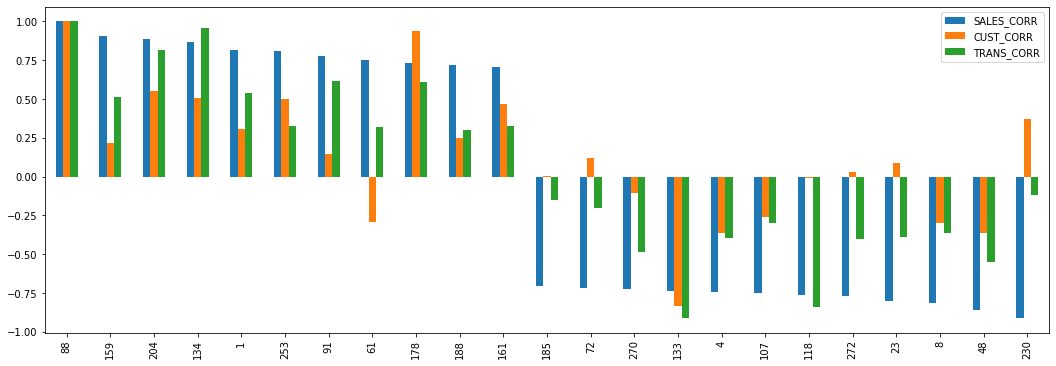

In [34]:
store_88_neigh[(store_88_neigh.SALES_CORR >= 0.7) | (store_88_neigh.SALES_CORR <= -0.7)].sort_values('SALES_CORR', ascending=False).plot(kind='bar', figsize=(18,6))

Now that we have selected Store 237 as a control store, we check how similar the distributions of Store 88 are similar to this store.


We check the distribution of following metrics from July 2018 to Jan 2019 i.e. before the trail period.
* Total Sales,
* No. of customer, and
* No. of transactions

<b>Total Sales Distribution</b>
<p>Both the pdfs are overlapping visually</p>

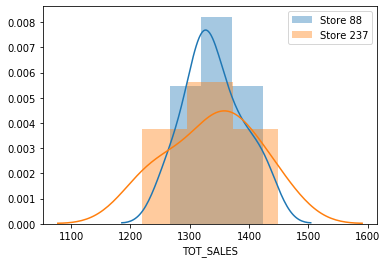

In [35]:
sns.distplot(all_store_perf[88][0], label=('Store 88'))
sns.distplot(all_store_perf[237][0], label=('Store 237'))

plt.legend()
plt.show()

<b>No. of Transactions each month distribution</b>
<p>Distributions seems to be overlapping here as well.</p>

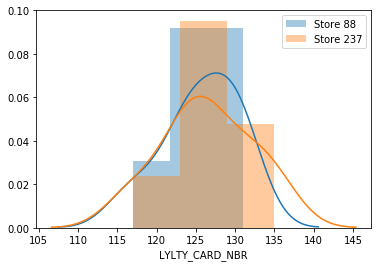

In [36]:
sns.distplot(all_store_perf[88][1], label=('Store 88'))
sns.distplot(all_store_perf[237][1], label=('Store 237'))

plt.legend()
plt.show()

<b>No. of Transactions each month distribution</b>
<p>Distributions seems to be overlapping here as well.</p>

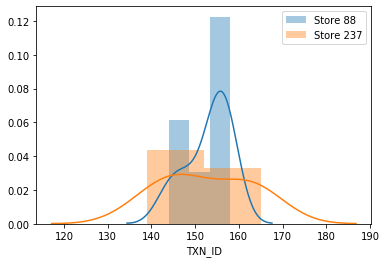

In [37]:
sns.distplot(all_store_perf[88][2], label=('Store 88'))
sns.distplot(all_store_perf[237][2], label=('Store 237'))

plt.legend()
plt.show()

To be sure that all above distributions of Store 233 are not significantally different from Store 77 we employ **Kolmogorov-Smirnov Statistic**.


This tests whether 2 samples are drawn from the same distribution. If the KS statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.


[Official Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html#scipy.stats.ks_2samp)

<b>NULL HYPOTHESIS </b>: Distributions of the two samples are the same.

In [38]:
# Total Sales

ks_2samp(all_store_perf[88][0], all_store_perf[237][0])

Ks_2sampResult(statistic=0.2857142857142857, pvalue=0.9627039627039629)

For total sales we see that the KS statistic is small or the p-value is high, therefore we cannot reject the hypothesis that the distributions of the two samples are the same.

In [39]:
# Number of Customers

ks_2samp(all_store_perf[88][1], all_store_perf[237][1])

Ks_2sampResult(statistic=0.2857142857142857, pvalue=0.9627039627039629)

For number of customers also we see that the p-value is high, therefore we cannot reject the hypothesis that the distributions of the two samples are the same.

In [40]:
# Number of Transactions

ks_2samp(all_store_perf[88][2], all_store_perf[237][2])

Ks_2sampResult(statistic=0.42857142857142855, pvalue=0.5751748251748252)

Here also we see that the p-value is high, therefore we cannot reject the hypothesis that the distributions of the two samples are the same.

<hr>

## Assessment of the trial

The trial period goes from the start of February 2019 to April 2019. We now want tosee if there has been an uplift in overall chip sales.


As our null hypothesis is that the trial period is the same as the pre-trial period, we will employ **T-test** for the means of two independent samples of scores to find whether the difference is significant or not.
 

We can use this test, if we observe two independent samples from the same or different population, e.g. exam scores of boys and girls or of two ethnic groups. The test measures whether the average (expected) value differs significantly across samples. If we observe a large p-value, for example larger than 0.05 or 0.1, then we cannot reject the null hypothesis of identical average scores. If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages.

[Official Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)

[Reference reading material](https://www.statisticshowto.com/t-statistic/)


**We will test with a null hypothesis of there being 0 difference between trial and control stores.**

<br>

We calculate the performance metrics of trial store and control store for trial period which is from Feb 2019 to April 2019.

In [41]:
trial_88 = calcStorePerf(88, start=8, end=11)
trial_237 = calcStorePerf(237, start=8, end=11)

<br>

<b>T-Test on Total Sales</b>

In [42]:
ttest_ind(trial_88[0], trial_237[0])

Ttest_indResult(statistic=3.984716931514837, pvalue=0.01633670985457616)

The results show that the **trial in store 88 is significantly different to its control store in the trial period** as the trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the three trial months.


Below we check distributions during the trail period and observe that they also seems different visually.

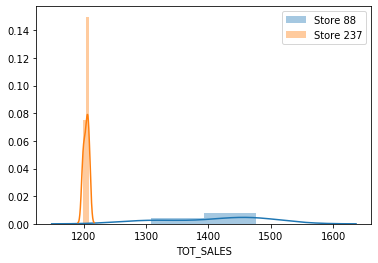

In [43]:
sns.distplot(trial_88[0], label=('Store 88'))
sns.distplot(trial_237[0], label=('Store 237'))

plt.legend()
plt.show()

T-Test on number of Customers

Ttest_indResult(statistic=1.9521843207154492, pvalue=0.12264932426178891)


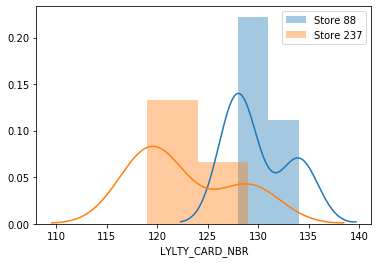

In [44]:
print(ttest_ind(trial_88[1], trial_237[1]))

sns.distplot(trial_88[1], label=('Store 88'))
sns.distplot(trial_237[1], label=('Store 237'))

plt.legend()
plt.show()

<b>CONCLUSION</b>

Total number of customers in the trial period for the trial store is significantly higher than the control store for two out of three months, which indicates a positive trial effect.

*** 

# Conclusion

We've found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.


The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the three trial months but this is not the case for trial store 86. We can check with the client if the implementation of the trial wasdifferent in trial store 86 but overall, the trial shows a significant increase in sales. Now that we have finished our analysis, we can prepare our presentation to the Category Manager.